<a href="https://colab.research.google.com/github/tikhongc/fyp/blob/main/Music_genre_Resnet_Transfer_Learning(3).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Library

In [ ]:
!pip install torchaudio

In [ ]:
import torch
import torchvision
import torchaudio
import random
import numpy as np
import librosa
import librosa.display
import pandas as pd
import os
from PIL import Image
import pathlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline
from tqdm.autonotebook import tqdm
import IPython.display as ipd
import torchvision.transforms as T
from torch.utils.data import random_split
import torchvision.models as models
import time
from sklearn.metrics import *
import seaborn as sns
%matplotlib inline

# Custom and create dataset

In [ ]:
img_path = '/content/drive/MyDrive/Dataset/Music-genre-classification/mel-spec-img/All_30s/'

为什么用 validation set:

workflow:

for each epoch

    for each training data instance

        propagate error through the network

        adjust the weights

        calculate the accuracy over training data

    for each validation data instance

        calculate the accuracy over the validation data

    if the threshold validation accuracy is met

        exit training

    else
    
        continue training

1.training sets是用作訓練時調整神經網絡的weights；

2.validation sets並不是用作調整weights，而是用作防止overfitting（過擬合）的。如果由training sets得到的精度隨着訓練的進行在增加，而這個模型經過validation sets計算後，發現精度與之前保持不變，或者精度反而下降了。這說明，已經產生overfitting了，需要停止訓練。也就是讓這個model在training sets與validation sets之間trade-off，更balance。

Mini-batches Learning: 
Batch_size不宜选的太小，太小了容易修正方向导致不收敛，或者需要经过很大的epoch才能收敛；也没必要选的太大，太大的话首先显存受不了，其次可能会因为迭代次数的减少而造成参数修正变的缓慢。 



In [ ]:
# 將數個資料組成一個批次，這裡一批包含 8 個樣本: (image, label)
batch_size = 8
# 影像大小
image_size = 224

 Custom dataset：



*   For training set: 把给定的图片resize到given size, Random Rotate the img , 以0.5的概率水平翻转给定的PIL图像,ToTensor() 将 PIL.Image/numpy.ndarray 数据进转化为torch.FloadTensor，并归一化到[0, 1.0].

*   For val set: resize and 归一化




 






In [ ]:
train_trms = T.Compose([T.Resize(image_size),T.RandomRotation(20),T.RandomHorizontalFlip(),T.ToTensor()])
val_trms = T.Compose([T.Resize(image_size),T.ToTensor()])

Create data sets :


In [ ]:
#root：find img under root
#transform：convert the img using indicated transform 

train_data = torchvision.datasets.ImageFolder(root = img_path, transform = train_trms)
val_data = torchvision.datasets.ImageFolder(root = img_path, transform = val_trms)

## Plot the data

In [ ]:
def Encode(data):
    classes = data.classes
    encoder = {}
    for i in range(len(classes)):
        encoder[i] = classes[i]
    return encoder

def Decoder(data):
    classes = data.classes
    decoder = {}
    for i in range(len(classes)):
        decoder[classes[i]] = i
    return decoder

In [ ]:
def class_plot(data,n_figures = 12):
    n_row = int(n_figures/4)
    fig,axes = plt.subplots(figsize=(14, 10), nrows = n_row, ncols=4)
    for ax in axes.flatten():
        a = random.randint(0,len(data))
        (image,label) = data[a]
#         print(type(image))
        label = int(label)
        encoder = Encode(data)
        l = encoder[label]
       
        image = image.numpy().transpose(1,2,0)
        im = ax.imshow(image)
        ax.set_title(l)
        ax.axis('off')
    plt.show()

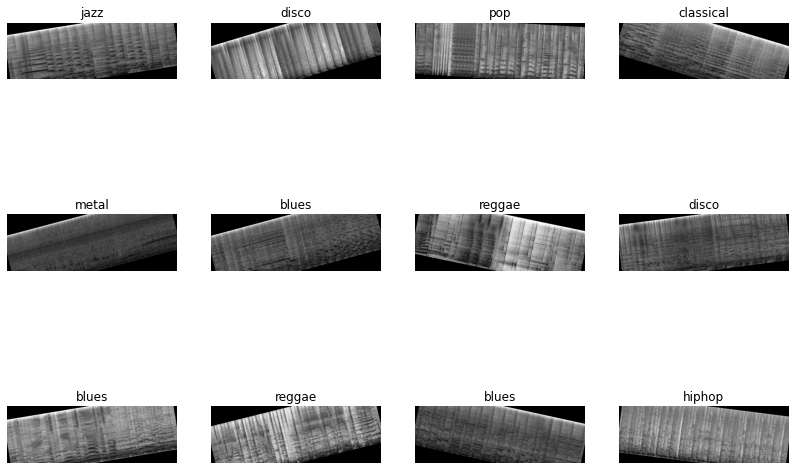

In [ ]:
class_plot(train_data)

## split the data into training and validation set

In [ ]:
# torch.manual_seed 43 用于设置随机初始化的种子，即上述的编号，编号固定，每次获取的随机数固定。
torch.manual_seed(43)

# define how much data we will give to the training and validation set. 
# In my case, I am giving  data to the validation set and % to the training set.
val_size = int(len(train_data)*0.2)
train_size = len(train_data) - val_size

for spliting we use Pytorch’s Dataloader class and random_split class.

In [ ]:
# randomly split the dataset into train set and val set
train_ds, val_ds = random_split(train_data, [train_size,val_size])
len(train_ds), len(val_ds)

(899, 99)

把做成的数据集放入Data.DataLoader中，可以生成一个迭代器，从而我们可以方便的进行批处理。

In here, i choose 2 times batch_size for validation dataset.

Reason : for validation_batch_size and test_batch_size, you should pick the largest batch size that your hardware can handle without running out of memory and crashing. Finding this is usually a simple trial and error process.

reference:https://stackoverflow.com/questions/54413160/training-validation-testing-batch-size-ratio

In [ ]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

plot the training set images:


images.shape: torch.Size([8, 3, 224, 673])


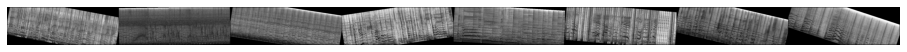

In [ ]:
for images, _ in train_dl:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

# Deep learning

The accuracy function which would evaluate our model would be:


In [ ]:
def accuracy(outputs, labels):
  _,preds = torch.max(outputs,dim=1)
  return torch.tensor(torch.sum(preds == labels).item()/len(preds))

! ! PyTorch 中網路模型的建立步驟:

https://iter01.com/524139.html

 I have used the Pretrained ResNet34 model which shot up the accuracy at a considerable rate, I also used the Learning rate Scheduler and Gradient Clipping

torch.nn是专门为神经网络设计的模块化接口。nn构建于autograd之上，可以用来定义和运行神经网络。nn.Module是nn中十分重要的类,包含网络各层的定义及forward方法。


reference:https://blog.csdn.net/zkq_1986/article/details/85249220

In [ ]:
class Base(nn.Module):
    def training_step(self, batch):
        # Generate predictions
        images, targets = batch 
        out = self(images)       
        # Calculate loss                                   
        loss = F.cross_entropy(out, targets)      
        return loss
    
    def validation_step(self, batch):
        images, targets = batch 
        # Generate predictions
        out = self(images)       
        # Calculate loss                    
        loss = F.cross_entropy(out, targets)  
        score = accuracy(out, targets)
        return {'val_loss': loss.detach(), 'val_score': score.detach() }
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   
        # Combine losses
        batch_scores = [x['val_score'] for x in outputs]
        epoch_score = torch.stack(batch_scores).mean()      
        # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_score': epoch_score.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_score: {:.4f}".format(epoch, result['val_loss'], result['val_score']))

## Transfer learning with Resnet 34

reference:


*   Building Resnet-34 model using Pytorch – A Guide for Beginners : https://www.analyticsvidhya.com/blog/2021/09/building-resnet-34-model-using-pytorch-a-guide-for-beginners/
*   How to Train a Custom Resnet34 Model for Image Classification in fastai and PyTorch : https://blog.roboflow.com/custom-resnet34-classification-model/

*   L14.3.2.2 ResNet-34 in PyTorch -- Code Example:
    https://www.youtube.com/watch?v=JG_ODvnlgjY

    https://github.com/rasbt/stat453-deep-learning-ss21/blob/main/L14/2-resnet34.ipynb



*   pytorch下分类神经网络的迁移学习transfer learning:
https://blog.csdn.net/LXX516/article/details/79019931


*   Transfer Learning: https://zhuanlan.zhihu.com/p/49407624












In [ ]:
class Net(Base):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet34(pretrained=True)
        # Replace last layer(the classifier)
        # 最后fc层的输入
        num_ftrs = self.network.fc.in_features
        # NUM_CLASSES是自己数据的类别
        NUM_CLASSES = 10
        self.network.fc = nn.Linear(num_ftrs, NUM_CLASSES)

    def forward(self, xb):
        return self.network(xb)

    def freeze(self):
      for param in self.network.parameters():
        param.require_grad = False
      for param in self.network.fc.parameters():
        param.require_grad = True
    
    def unfreeze(self):
      for param in self.network.parameters():
        param.require_grad = True

In [ ]:
Net()

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

Net(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running

The evaluate function that will help to evaluate the model on the validation set:


In [ ]:
def evaluate(model,val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

define the fit function with Gradient Clipping, Learning Rate Scheduler, weight decay and optimizer that we will use is Adam.


Pytorch调整学习率的方法:https://zhuanlan.zhihu.com/p/110018001

In [ ]:
@torch.no_grad()
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

https://blog.csdn.net/PanYHHH/article/details/107361827

gradient clipping ： https://blog.csdn.net/weixin_39653948/article/details/105962326

Working Flow：

加载训练数据和标签

模型输入输出

计算loss函数值

loss 反向传播

梯度截断

优化器更新梯度参数

In [ ]:
def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):

    # recycle the not used gpu
    torch.cuda.empty_cache()
    history = []

    # set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)

    # set up one-cycle learning rate scheduler
    # 在每次更新参数前迭代更改学习率 
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))

    for epoch in range(epochs):

        # training phase 
        model.train()
        lrs = []
        for batch in tqdm(train_loader):

            loss = model.training_step(batch)
            # used to backpropagete to adjust the paramters according to the loss
            loss.backward()

            # gradient clipping
            # 通过重新缩放误差导数，权重的更新也将被重新缩放，从而大大降低了上溢或下溢的可能性
            # Clips gradients computed during backpropagation to avoid explosion of gradients.
            # 将梯度约束在某一个区间之内，在训练的过程中，在优化器更新之前进行梯度截断操作
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            # update the parameters    
            optimizer.step()
            
            # should zero out the gradients so that you do the parameter update correctly. Otherwise, the gradient would be a combination of the old gradient
            optimizer.zero_grad()

            # record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()

        # validation phase
        result = evaluate(model, val_loader)
        result['lrs'] = lrs
        model.epoch_end(epoch, result)

        history.append(result)
    return history

### Get GPU (not need on google colab)

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

# Evaluate and Training transfer learning model

initialize the model

In [ ]:
model = to_device(Net(), device)

In [ ]:
torch.cuda.empty_cache()

In [ ]:
history = [evaluate(model,val_dl)]

freezing prevents the weights of a neural network layer from being modified during the backward pass of training. You progressively 'lock-in' the weights for each layer to reduce the amount of computation in the backward pass and decrease training time.

What are the effects of layer freezing? The consequences are:

(1) Should be faster to train (the gradient will have far less components)

(2) Should require less data to train on

reference : What Does Freezing A Layer Mean And How Does It Help In Fine Tuning Neural Networks -- 
https://analyticsindiamag.com/what-does-freezing-a-layer-mean-and-how-does-it-help-in-fine-tuning-neural-networks/

**we will freeze the layers of the model except the last layer because the model is already trained and we don’t need to train it any further, the last layer is the one which has to be trained. For that, we will call the function we made earlier while making the model.**

In [ ]:
model.freeze()

Now, we will define the hyperparameters of our model i.e. max learning rate, gradient clipping factor, weight decay, and optimizer.

调整参数;https://codertw.com/%E7%A8%8B%E5%BC%8F%E8%AA%9E%E8%A8%80/486730/

In [ ]:
epochs = 5
# 如果學習率太小，代表對神經網絡進行非常小的權重更新，會使其訓練變非常緩慢；然後學習率太大，可能導致無法收斂
max_lr = 0.001
# 如果梯度值小於-0.1,則將其設置為-0.1，如果大於0.1，則將其設置為0.1。
grad_clip = 0.1
# 正则项的系数,如果太大，会极大的抑制参数的更新，导致欠拟合，如果太小，那么正则项这个部分基本没有贡献
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [ ]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, val_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)

  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [0], val_loss: 1.8051, val_score: 0.4345


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [1], val_loss: 1.8958, val_score: 0.4048


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [2], val_loss: 1.4294, val_score: 0.5595


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [3], val_loss: 1.0594, val_score: 0.6488


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [4], val_loss: 0.9531, val_score: 0.6577
CPU times: user 1min 9s, sys: 57.1 s, total: 2min 6s
Wall time: 3min 45s


Now train the model a little more with more epochs.

In [ ]:
%%time
history += fit_one_cycle(15, max_lr, model, train_dl, val_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)

  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [0], val_loss: 1.0221, val_score: 0.7113


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [1], val_loss: 1.3521, val_score: 0.5417


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [2], val_loss: 1.3541, val_score: 0.5952


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [3], val_loss: 1.3548, val_score: 0.5208


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [4], val_loss: 1.1388, val_score: 0.5595


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [5], val_loss: 1.3444, val_score: 0.5030


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [6], val_loss: 1.2470, val_score: 0.5744


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [7], val_loss: 1.0758, val_score: 0.6250


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [8], val_loss: 1.0459, val_score: 0.6488


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [9], val_loss: 0.8707, val_score: 0.7500


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [10], val_loss: 0.8156, val_score: 0.7946


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [11], val_loss: 0.9260, val_score: 0.7113


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [12], val_loss: 0.7871, val_score: 0.7768


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [13], val_loss: 0.8520, val_score: 0.7946


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [14], val_loss: 0.7859, val_score: 0.7857
CPU times: user 3min 28s, sys: 2min 49s, total: 6min 18s
Wall time: 6min 12s


unfreeze the weight :

performance would be better because you are adjusting  the parameters to your specific problem at hand. 

https://juejin.cn/post/6844904078888140814

In [ ]:
model.unfreeze()

Training after unfreezing the layers:


In [ ]:
%%time
history += fit_one_cycle(50, max_lr, model, train_dl, val_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)

  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [0], val_loss: 0.8817, val_score: 0.7679


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [1], val_loss: 0.7980, val_score: 0.8125


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [2], val_loss: 0.8898, val_score: 0.7500


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [3], val_loss: 0.9296, val_score: 0.7292


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [4], val_loss: 0.8130, val_score: 0.7857


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [5], val_loss: 0.8974, val_score: 0.7321


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [6], val_loss: 0.8604, val_score: 0.7589


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [7], val_loss: 0.9918, val_score: 0.7143


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [8], val_loss: 1.0710, val_score: 0.6875


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [9], val_loss: 1.2169, val_score: 0.6220


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [10], val_loss: 0.9987, val_score: 0.7321


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [11], val_loss: 0.9998, val_score: 0.6935


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [12], val_loss: 0.9834, val_score: 0.7321


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [13], val_loss: 1.1212, val_score: 0.7232


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [14], val_loss: 1.0735, val_score: 0.6964


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [15], val_loss: 1.1253, val_score: 0.6577


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [16], val_loss: 1.0026, val_score: 0.6964


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [17], val_loss: 1.0569, val_score: 0.7143


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [18], val_loss: 0.9170, val_score: 0.7321


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [19], val_loss: 1.0801, val_score: 0.6875


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [20], val_loss: 0.9487, val_score: 0.7500


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [21], val_loss: 1.0406, val_score: 0.6488


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [22], val_loss: 0.8383, val_score: 0.7768


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [23], val_loss: 1.0241, val_score: 0.6607


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [24], val_loss: 1.1192, val_score: 0.7113


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [25], val_loss: 0.9715, val_score: 0.7321


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [26], val_loss: 1.0706, val_score: 0.6786


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [27], val_loss: 0.9147, val_score: 0.7768


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [28], val_loss: 1.0763, val_score: 0.7411


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [29], val_loss: 1.1893, val_score: 0.7411


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [30], val_loss: 0.9086, val_score: 0.7768


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [31], val_loss: 1.1613, val_score: 0.7589


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [32], val_loss: 0.9162, val_score: 0.7857


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [33], val_loss: 1.0523, val_score: 0.7411


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [34], val_loss: 1.2454, val_score: 0.7500


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [35], val_loss: 1.1366, val_score: 0.7768


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [36], val_loss: 1.1473, val_score: 0.7768


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [37], val_loss: 1.1506, val_score: 0.7202


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [38], val_loss: 0.9656, val_score: 0.7768


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [39], val_loss: 1.1968, val_score: 0.7946


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [40], val_loss: 1.3338, val_score: 0.7679


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [41], val_loss: 1.2638, val_score: 0.7679


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [42], val_loss: 1.0412, val_score: 0.7946


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [43], val_loss: 1.2057, val_score: 0.7679


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [44], val_loss: 1.0913, val_score: 0.7946


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [45], val_loss: 1.2245, val_score: 0.7946


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [46], val_loss: 1.1783, val_score: 0.8036


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [47], val_loss: 1.3539, val_score: 0.7768


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [48], val_loss: 1.2235, val_score: 0.8125


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [49], val_loss: 1.1770, val_score: 0.7857
CPU times: user 11min 37s, sys: 9min 22s, total: 21min
Wall time: 20min 41s


In [ ]:
%%time
history += fit_one_cycle(20, max_lr, model, train_dl, val_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)

  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [0], val_loss: 1.3692, val_score: 0.8036


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [1], val_loss: 1.3304, val_score: 0.7679


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [2], val_loss: 1.0229, val_score: 0.7679


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [3], val_loss: 1.1857, val_score: 0.7500


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [4], val_loss: 1.4660, val_score: 0.6161


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [5], val_loss: 0.9645, val_score: 0.7679


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [6], val_loss: 1.1378, val_score: 0.6875


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [7], val_loss: 1.2786, val_score: 0.7411


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [8], val_loss: 1.2342, val_score: 0.7411


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [9], val_loss: 0.9306, val_score: 0.7768


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [10], val_loss: 1.1127, val_score: 0.7589


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [11], val_loss: 0.8984, val_score: 0.7768


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [12], val_loss: 1.0727, val_score: 0.7768


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [13], val_loss: 1.0619, val_score: 0.7857


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [14], val_loss: 1.0440, val_score: 0.7857


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [15], val_loss: 1.0490, val_score: 0.7411


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [16], val_loss: 1.0736, val_score: 0.8304


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [17], val_loss: 1.1285, val_score: 0.8125


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [18], val_loss: 1.1703, val_score: 0.7857


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [19], val_loss: 1.0421, val_score: 0.7857
CPU times: user 4min 38s, sys: 3min 46s, total: 8min 24s
Wall time: 8min 16s


In [ ]:
def plot_losses(history):
    losses = [x['val_loss'] for x in history]
    plt.plot(losses, '-x')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Loss vs. No. of epochs');
def plot_accuracies(history):
    accuracies = [x['val_score'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

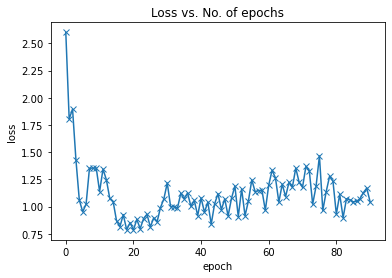

In [ ]:
plot_losses(history)

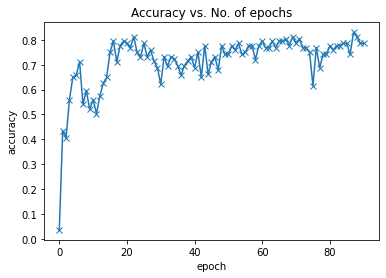

In [ ]:
plot_accuracies(history)

In [ ]:
torch.save(model, '/content/drive/MyDrive/Dataset/Music-genre-classification/model/resnet_model3.pt')

In [ ]:
model = torch.load('/content/drive/MyDrive/Dataset/Music-genre-classification/model/resnet_model3.pt')
model.eval()

Net(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running

In [ ]:
# Saving the model to h5 file
torch.save(model.state_dict(), '/content/drive/MyDrive/Dataset/Music-genre-classification/model/resnet_model3.h5')

# Testing of transfer learning trained model

In [ ]:
val_size = int(len(train_data)*0.2)
train_size = len(train_data) - val_size
train_ds1, val_ds1 = random_split(train_data, [train_size,val_size])
batch_size=4
val_dl1 = DataLoader(val_ds1,batch_size,num_workers=4,pin_memory=True)

In [ ]:
len(train_ds1), len(val_ds1)

(799, 199)

In [ ]:
testloader = val_dl
# Collect training time and result
current_time = time.time()
result = evaluate(model, testloader)
result
print('Training time: {:.2f} s'.format(time.time() - current_time))

Training time: 0.75 s


In [ ]:
# Generate testing accuracy, predicted label, confusion matrix, and table for classification report
def test_label_predictions(model, device, test_loader):
    model.eval()
    actuals = []
    predictions = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            prediction = output.argmax(dim=1, keepdim=True)
            actuals.extend(target.view_as(prediction))
            predictions.extend(prediction)
    return [i.item() for i in actuals], [i.item() for i in predictions]


In [ ]:
label=['blues','classical','country','disco','hiphop','jazz','metal','pop','reggae','rock']
target_names = sorted(set(label))
y_test, y_pred = test_label_predictions(model, device, testloader)
cm=confusion_matrix(y_test, y_pred)
cr=classification_report(y_test, y_pred, target_names=target_names)
fs=f1_score(y_test,y_pred,average='weighted')
rs=recall_score(y_test, y_pred,average='weighted')
accuracy=accuracy_score(y_test, y_pred)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Confusion matrix:


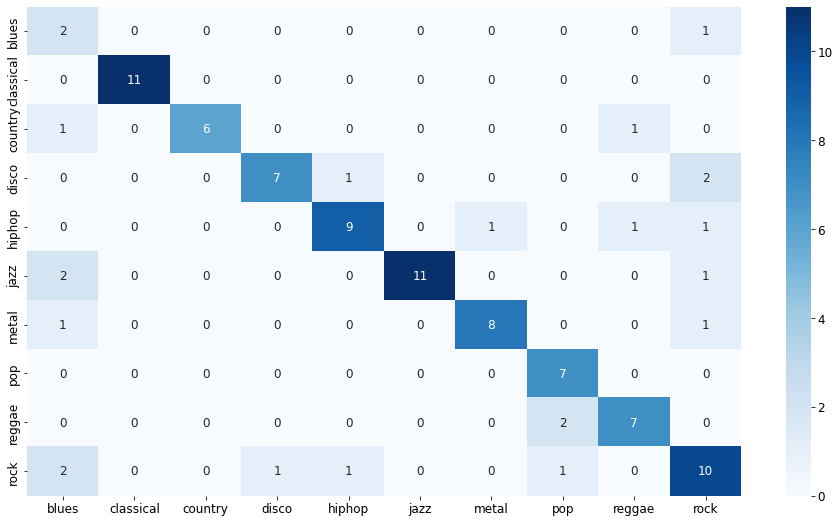

In [ ]:
print('Confusion matrix:')
plt.figure(figsize = (16, 9))
sns.heatmap(cm,cmap="Blues", annot=True, xticklabels = target_names, yticklabels = target_names )

In [ ]:
print(cr)
print('F1 score: %f' % fs)
print('Recall score: %f' % rs)
print('Accuracy score: %f' % accuracy)

              precision    recall  f1-score   support

       blues       0.25      0.67      0.36         3
   classical       1.00      1.00      1.00        11
     country       1.00      0.75      0.86         8
       disco       0.88      0.70      0.78        10
      hiphop       0.82      0.75      0.78        12
        jazz       1.00      0.79      0.88        14
       metal       0.89      0.80      0.84        10
         pop       0.70      1.00      0.82         7
      reggae       0.78      0.78      0.78         9
        rock       0.62      0.67      0.65        15

    accuracy                           0.79        99
   macro avg       0.79      0.79      0.77        99
weighted avg       0.83      0.79      0.80        99

F1 score: 0.801013
Recall score: 0.787879
Accuracy score: 0.787879


In [ ]:
# Save classificationreport into csv
report = classification_report(y_test, y_pred, output_dict = True,target_names=target_names)
df=pd.DataFrame(report).transpose()
df.to_csv('/content/drive/MyDrive/Dataset/Music-genre-classification/model/classificationreport.csv',index=False)

In [ ]:
df

,precision,recall,f1-score,support
blues,0.250000,0.666667,0.363636,3.000000
classical,1.000000,1.000000,1.000000,11.000000
country,1.000000,0.750000,0.857143,8.000000
disco,0.875000,0.700000,0.777778,10.000000
hiphop,0.818182,0.750000,0.782609,12.000000
jazz,1.000000,0.785714,0.880000,14.000000
metal,0.888889,0.800000,0.842105,10.000000
pop,0.700000,1.000000,0.823529,7.000000
reggae,0.777778,0.777778,0.777778,9.000000
rock,0.625000,0.666667,0.645161,15.000000


In [ ]:
# Obtain training accuracy
y_train, y_pred2 = test_label_predictions(model, device, train_dl)
train_accuracy=accuracy_score(y_train, y_pred2)
print('Train accuracy: %f' % train_accuracy)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train accuracy: 1.000000


# Neural Network（without transfer learning）:

pytorch使用torch.nn.Sequential快速搭建神经网络:

reference:https://ptorch.com/news/57.html

In [ ]:
class Net1(Base):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3,32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(32,64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(64,64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(64,128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(128,128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(128,256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(1),

            nn.Flatten(), 
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 10)
        )
        
    def forward(self, xb):
        return self.network(xb)

In [ ]:
Net1()

Net1(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (16):

In [ ]:
model1 = to_device(Net1(), device)
torch.cuda.empty_cache()

In [ ]:
history = [evaluate(model1,val_dl)]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
epochs = 5
# 如果學習率太小，代表對神經網絡進行非常小的權重更新，會使其訓練變非常緩慢；然後學習率太大，可能導致無法收斂
max_lr = 0.001
# 如果梯度值小於-0.1,則將其設置為-0.1，如果大於0.1，則將其設置為0.1。
grad_clip = 0.1
# 正则项的系数,如果太大，会极大的抑制参数的更新，导致欠拟合，如果太小，那么正则项这个部分基本没有贡献
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [ ]:
%%time
history += fit_one_cycle(epochs, max_lr, model1, train_dl, val_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)

  0%|          | 0/113 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], val_loss: 2.3101, val_score: 0.1369


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [1], val_loss: 2.3121, val_score: 0.1369


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [2], val_loss: 2.3125, val_score: 0.0268


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [3], val_loss: 2.3113, val_score: 0.0268


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [4], val_loss: 2.3114, val_score: 0.0268
CPU times: user 34.5 s, sys: 26.2 s, total: 1min
Wall time: 1min 49s


In [ ]:
%%time
history += fit_one_cycle(20, max_lr, model1, train_dl, val_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)

  0%|          | 0/113 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], val_loss: 2.3114, val_score: 0.0268


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [1], val_loss: 2.3088, val_score: 0.0744


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [2], val_loss: 2.2115, val_score: 0.2083


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [3], val_loss: 2.0916, val_score: 0.1637


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [4], val_loss: 2.0475, val_score: 0.2262


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [5], val_loss: 2.1127, val_score: 0.1994


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [6], val_loss: 2.1386, val_score: 0.1994


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [7], val_loss: 2.1535, val_score: 0.1815


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [8], val_loss: 2.0703, val_score: 0.2083


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [9], val_loss: 2.0377, val_score: 0.1815


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [10], val_loss: 2.1350, val_score: 0.1458


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [11], val_loss: 2.0644, val_score: 0.1815


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [12], val_loss: 2.0486, val_score: 0.1637


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [13], val_loss: 2.0410, val_score: 0.1815


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [14], val_loss: 2.0504, val_score: 0.1815


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [15], val_loss: 2.0518, val_score: 0.1637


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [16], val_loss: 2.0405, val_score: 0.1905


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [17], val_loss: 2.0518, val_score: 0.1815


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [18], val_loss: 2.0465, val_score: 0.2083


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [19], val_loss: 2.0382, val_score: 0.1815
CPU times: user 2min 30s, sys: 1min 55s, total: 4min 26s
Wall time: 5min 41s


In [ ]:
%%time
history += fit_one_cycle(50, max_lr, model1, train_dl, val_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)

  0%|          | 0/113 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], val_loss: 2.0555, val_score: 0.1815


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [1], val_loss: 2.0334, val_score: 0.1815


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [2], val_loss: 2.0289, val_score: 0.1726


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [3], val_loss: 2.0372, val_score: 0.2083


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [4], val_loss: 2.0335, val_score: 0.1815


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [5], val_loss: 2.0346, val_score: 0.1994


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [6], val_loss: 2.0369, val_score: 0.1548


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [7], val_loss: 2.0613, val_score: 0.1637


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [8], val_loss: 2.0381, val_score: 0.1905


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [9], val_loss: 2.1189, val_score: 0.1905


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [10], val_loss: 2.0538, val_score: 0.1726


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [11], val_loss: 2.0705, val_score: 0.2262


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [12], val_loss: 2.0658, val_score: 0.1815


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [13], val_loss: 2.0846, val_score: 0.1726


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [14], val_loss: 2.0986, val_score: 0.1994


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [15], val_loss: 2.1218, val_score: 0.1994


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [16], val_loss: 2.0260, val_score: 0.1994


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [17], val_loss: 2.0227, val_score: 0.1815


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [18], val_loss: 2.0704, val_score: 0.1815


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [19], val_loss: 2.0491, val_score: 0.1905


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [20], val_loss: 2.0182, val_score: 0.1994


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [21], val_loss: 2.0523, val_score: 0.1458


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [22], val_loss: 2.0514, val_score: 0.1548


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [23], val_loss: 2.0609, val_score: 0.1815


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [24], val_loss: 2.0909, val_score: 0.1548


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [25], val_loss: 2.0548, val_score: 0.1637


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [26], val_loss: 2.0433, val_score: 0.1637


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [27], val_loss: 2.0144, val_score: 0.2083


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [28], val_loss: 2.0472, val_score: 0.1815


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [29], val_loss: 2.0279, val_score: 0.2470


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [30], val_loss: 1.9541, val_score: 0.3006


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [31], val_loss: 2.0488, val_score: 0.2262


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [32], val_loss: 1.9878, val_score: 0.3006


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [33], val_loss: 1.8981, val_score: 0.3363


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [34], val_loss: 1.9911, val_score: 0.3185


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [35], val_loss: 1.8766, val_score: 0.3185


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [36], val_loss: 1.9030, val_score: 0.3363


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [37], val_loss: 1.8764, val_score: 0.3006


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [38], val_loss: 1.8740, val_score: 0.2827


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [39], val_loss: 1.8584, val_score: 0.3274


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [40], val_loss: 1.8592, val_score: 0.3363


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [41], val_loss: 1.7613, val_score: 0.3631


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [42], val_loss: 1.8447, val_score: 0.3363


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [43], val_loss: 1.7991, val_score: 0.3095


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [44], val_loss: 1.8262, val_score: 0.2708


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [45], val_loss: 1.8163, val_score: 0.3542


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [46], val_loss: 1.8286, val_score: 0.3452


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [47], val_loss: 1.7622, val_score: 0.3363


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [48], val_loss: 1.7882, val_score: 0.3452


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [49], val_loss: 1.7975, val_score: 0.3452
CPU times: user 6min 1s, sys: 4min 31s, total: 10min 33s
Wall time: 14min 18s


In [ ]:
%%time
history += fit_one_cycle(20, max_lr, model1, train_dl, val_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)

  0%|          | 0/113 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], val_loss: 1.8212, val_score: 0.3542


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [1], val_loss: 1.9124, val_score: 0.2798


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [2], val_loss: 1.7890, val_score: 0.3720


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [3], val_loss: 1.7988, val_score: 0.3452


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [4], val_loss: 1.7451, val_score: 0.2976


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [5], val_loss: 1.6829, val_score: 0.3988


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [6], val_loss: 1.7427, val_score: 0.3065


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [7], val_loss: 1.6450, val_score: 0.3899


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [8], val_loss: 1.6324, val_score: 0.4256


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [9], val_loss: 1.6095, val_score: 0.4167


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [10], val_loss: 1.6769, val_score: 0.3839


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [11], val_loss: 1.6419, val_score: 0.4018


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [12], val_loss: 1.6916, val_score: 0.4435


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [13], val_loss: 1.5196, val_score: 0.3958


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [14], val_loss: 1.6678, val_score: 0.4345


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [15], val_loss: 1.5259, val_score: 0.4970


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [16], val_loss: 1.4859, val_score: 0.4970


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [17], val_loss: 1.5388, val_score: 0.4613


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [18], val_loss: 1.5151, val_score: 0.5238


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [19], val_loss: 1.5052, val_score: 0.4792
CPU times: user 2min 37s, sys: 2min 5s, total: 4min 43s
Wall time: 5min 39s


In [ ]:
def plot_losses(history):
    losses = [x['val_loss'] for x in history]
    plt.plot(losses, '-x')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Loss vs. No. of epochs');
def plot_accuracies(history):
    accuracies = [x['val_score'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

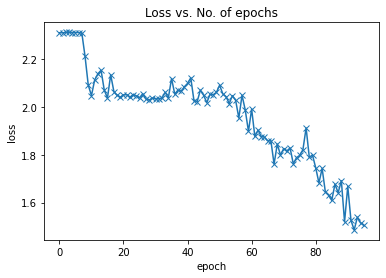

In [ ]:
plot_losses(history)

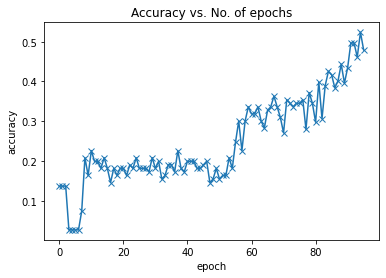

In [ ]:
plot_accuracies(history)

In [ ]:
torch.save(model1.state_dict(), '/content/drive/MyDrive/Dataset/Music-genre-classification/model/deep_learning_model.pth')

# Testing the deep learning model 

In [ ]:
val_size = int(len(train_data)*0.2)
train_size = len(train_data) - val_size
train_ds, val_ds = random_split(train_data, [train_size,val_size])
len(train_ds), len(val_ds)
val_dl = DataLoader(val_ds,1,num_workers=4,pin_memory=True)

In [ ]:
testloader = val_dl
# Collect training time and result
current_time = time.time()
result = evaluate(model1, testloader)
result
print('Training time: {:.2f} s'.format(time.time() - current_time))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Training time: 1.29 s


In [ ]:
# Saving the model to h5 file
torch.save(model1.state_dict(), '/content/drive/MyDrive/Dataset/Music-genre-classification/model/deeplearning_model1.h5')

In [ ]:
# Generate testing accuracy, predicted label, confusion matrix, and table for classification report
def test_label_predictions(model, device, test_loader):
    model.eval()
    actuals = []
    predictions = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            prediction = output.argmax(dim=1, keepdim=True)
            actuals.extend(target.view_as(prediction))
            predictions.extend(prediction)
    return [i.item() for i in actuals], [i.item() for i in predictions]

In [ ]:
label=['blues','classical','country','disco','hiphop','jazz','metal','pop','reggae','rock']
target_names = sorted(set(label))
y_test, y_pred = test_label_predictions(model1, device, testloader)
cm=confusion_matrix(y_test, y_pred)
cr=classification_report(y_test, y_pred, target_names=target_names)
fs=f1_score(y_test,y_pred,average='weighted')
rs=recall_score(y_test, y_pred,average='weighted')
accuracy=accuracy_score(y_test, y_pred)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Confusion matrix:


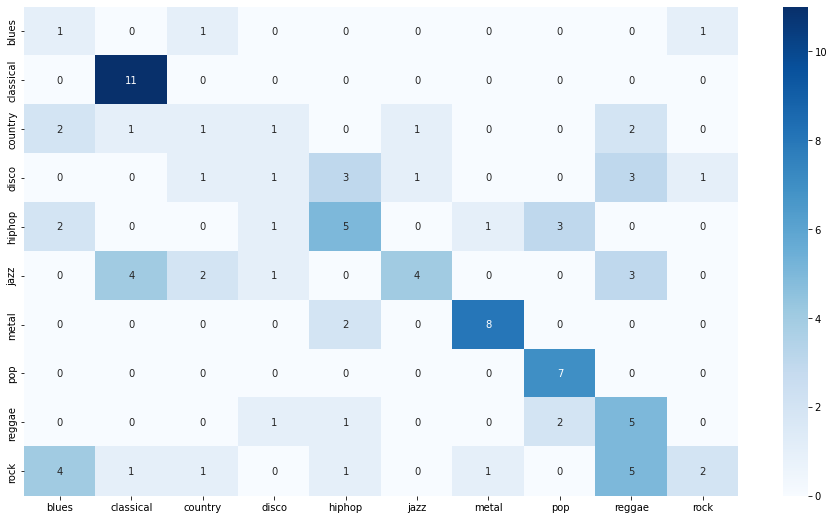

In [ ]:
print('Confusion matrix:')
plt.figure(figsize = (16, 9))
sns.heatmap(cm,cmap="Blues", annot=True, xticklabels = target_names, yticklabels = target_names )

In [ ]:
print(cr)
print('F1 score: %f' % fs)
print('Recall score: %f' % rs)
print('Accuracy score: %f' % accuracy)

              precision    recall  f1-score   support

       blues       0.11      0.33      0.17         3
   classical       0.65      1.00      0.79        11
     country       0.17      0.12      0.14         8
       disco       0.20      0.10      0.13        10
      hiphop       0.42      0.42      0.42        12
        jazz       0.67      0.29      0.40        14
       metal       0.80      0.80      0.80        10
         pop       0.58      1.00      0.74         7
      reggae       0.28      0.56      0.37         9
        rock       0.50      0.13      0.21        15

    accuracy                           0.45        99
   macro avg       0.44      0.47      0.42        99
weighted avg       0.48      0.45      0.42        99

F1 score: 0.422911
Recall score: 0.454545
Accuracy score: 0.454545


In [ ]:
# Save classificationreport into csv
report = classification_report(y_test, y_pred, output_dict = True,target_names=target_names)
df=pd.DataFrame(report).transpose()
df.to_csv('/content/drive/MyDrive/Dataset/Music-genre-classification/model/classificationreport.csv',index=False)

In [ ]:
df

,precision,recall,f1-score,support
blues,0.111111,0.333333,0.166667,3.000000
classical,0.647059,1.000000,0.785714,11.000000
country,0.166667,0.125000,0.142857,8.000000
disco,0.200000,0.100000,0.133333,10.000000
hiphop,0.416667,0.416667,0.416667,12.000000
jazz,0.666667,0.285714,0.400000,14.000000
metal,0.800000,0.800000,0.800000,10.000000
pop,0.583333,1.000000,0.736842,7.000000
reggae,0.277778,0.555556,0.370370,9.000000
rock,0.500000,0.133333,0.210526,15.000000


In [ ]:
# Obtain training accuracy
y_train, y_pred2 = test_label_predictions(model1, device, train_dl)
train_accuracy=accuracy_score(y_train, y_pred2)
print('Train accuracy: %f' % train_accuracy)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train accuracy: 0.487208
